In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft
from io import BytesIO

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

/tmp/ipykernel_42777/675125867.py:5: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy import ndimage
2025-11-18 20:43:43.241518: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 20:43:43.263394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-18 20:43:43.263406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-18 20:43:43.264130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to regi

In [2]:
k = 2   # kernel size
beta2s = [1, 0, 0.25, 0.5, 0.75] #[0, 0.25, 0.75, 1]  
activations = [tf.nn.relu]
timestamps = [1,5,10]
experiment_name = "unipolar_single_pixel"
box_dims = [20, 16]
step =   2 # Plot axis step

In [3]:
tf.nn.relu.__name__

'relu'

(7, 7)


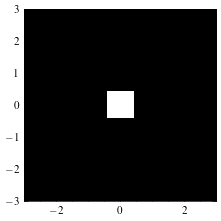

In [4]:
d = 7
mid = d//2
img = np.zeros((d,d)) # cv2.imread('input4.png', 0)/255. 

mid = img.shape[0]//2
img[mid, mid] = 1.
print(img.shape)


plt.imshow(img, cmap="gray", origin="lower",
           extent=[-mid, mid, -mid, mid])
plt.savefig("test_pixel.pdf")


In [5]:
# Single pixel input

img = np.zeros((115,115)) # cv2.imread('input4.png', 0)/255. 
mid = img.shape[0]//2
img[mid, mid] = 1.
print(img.shape)

(115, 115)


In [6]:
filters = np.zeros((3,3,1,1))
img = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 


2025-11-18 20:43:44.479879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-18 20:43:44.520812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-18 20:43:44.521958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
'''import matplotlib.patches as mpatches



filters = np.zeros((3,3,1,1))
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 



#Get image height and width

vals_x = img[0, img.shape[1]//2, :, :]
vals_y = img[0, :, img.shape[2]//2, :]
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
	length_y = nonzeros[-1] - nonzeros[0] + 1
else:
	length_y = 0  # all zeros
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
	length_x = nonzeros[-1] - nonzeros[0] + 1
else:
	length_x = 0  # all zeros



#step = 2**np.floor(np.log2(( (length_x) + np.max(timestamps) )// 5))


max_x = int(box_dims[0]*(.7))
min_x = -int(box_dims[0]*(.3))

max_y = box_dims[1]//2
min_y = -(box_dims[1]//2)

print(max_y, min_y)
print(length_x, length_y)


for activation in activations:
	for beta2 in beta2s:

		
		images = []

		filters = np.zeros((3,3,1,1))

		t = np.zeros((2,2))
		t[0,1] = np.sqrt(beta2)
		t[0, 0] = np.sqrt(1-beta2)


	
	
		#filters /= np.sum(np.abs(filters))
		
		w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)


		x = img


		directory = f"figures/{experiment_name}_{activation.__name__}_{k}x{k}_{beta2}"
		if not os.path.exists(directory):
			os.makedirs(directory)


		for i in range(timestamps[-1]+1):
			if i in timestamps:
				fig, ax = plt.subplots()
				x = x/np.std(x)
				vals = x[0, x.shape[1]//2, :, :]
				vals = vals/np.sum(vals)

				pos = np.expand_dims(np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),-1)
				mean = tf.reduce_sum(pos*vals)
				var = tf.reduce_sum(((pos-mean)**2) * vals)
				std = np.sqrt(var)
				#print(mean, np.sqrt(var))
				
				im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
				ax.plot(mid, mid, marker = '+', color='red')

				"""arr =  mpatches.FancyArrowPatch((mid, mid), (mid+mean+std, mid),
										mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
				ax.add_patch(arr)"""


				ax.annotate(r'$\sigma_x=$'+f"{std:.2f}", (0.05,0.01), ha='left', va='bottom',color='white', xycoords='axes fraction')
				ax.annotate(r'$\mu_x=$'+f"{mean:.2f}", (0.05,0.09), ha='left', va='bottom',color='white', xycoords='axes fraction')
				ax.annotate(r'$argmax_x=$'+f"{np.argmax(vals)-mid:.2f}", (0.05,.17), ha='left', va='bottom',color='white', xycoords='axes fraction')
				
				#ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
				#ax.arrow(, 112, dx=, dy= 0, color='black')




				ax.set(xlim=((mid + min_x, mid+max_x)) , ylim=((mid+min_y, (mid+max_y))))

				# Re-label ticks relative to midpoint
				xticks = ax.get_xticks()
				yticks = ax.get_yticks()

				#ax.set_xticklabels(np.arange(min_x, max_x+1, step=2))
				#ax.set_yticklabels(np.arange(min_y, max_y+1, step=2))
				xticks = np.arange(np.sign(min_x) * (np.abs(min_x)//2)*2, step+(max_x//2)*2, step=step) + mid
				yticks = np.arange(np.sign(min_y) * (np.abs(min_y)//2)*2, step+(max_y//2)*2, step=step) + mid
				ax.set_xticks(xticks)
				ax.set_yticks(yticks)

				ax.set_xticklabels([x - mid for x in xticks])
				ax.set_yticklabels([y - mid for y in yticks])



				#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
				#fig.colorbar(im, orientation='vertical')

				plt.close(fig) 
				buf = BytesIO()
				fig.savefig(buf, format="png", dpi=fig.dpi, bbox_inches="tight")
				buf.seek(0)


				images.append(Image.open(buf))

			filters = np.zeros((3,3,1,1))

			if i%2 == 0:
				filters[1:,0:2 ,0,0] = fft.idctn(t, norm="ortho")
			else:
				filters[0:2,1: ,0,0] = fft.idctn(t, norm="ortho")
			print(filters[:,:,0,0])
			w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)


			x = activation( tf.nn.conv2d(x, w , strides=(1,1), 
									padding='SAME') )
		
		#Generate Plot
		fig = plt.figure(figsize=(16,4))
		gs = fig.add_gridspec(1,len(timestamps)+1, wspace=0.04)

		ax0 = fig.add_subplot(gs[0])
		ax0.imshow(plot_filter_x(beta2))
		ax0.axis('off')
		for i, im in enumerate(images):	
			ax0 = fig.add_subplot(gs[i+1])
			ax0.imshow(im)
			ax0.axis('off')
			ax0.set_title(f"t={timestamps[i]}")

		fig.subplots_adjust(left=0.02, right=0.98, top=0.9, bottom=0.01, wspace=0.01)
		fig.savefig(f"{experiment_name}_{k}x{k}__{activation.__name__}_{beta2}.png", format="png", dpi=fig.dpi, bbox_inches="tight")
'''

'import matplotlib.patches as mpatches\n\n\n\nfilters = np.zeros((3,3,1,1))\nx = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) \n\n\n\n#Get image height and width\n\nvals_x = img[0, img.shape[1]//2, :, :]\nvals_y = img[0, :, img.shape[2]//2, :]\nnonzeros = np.nonzero(vals_x)[0]\nif nonzeros.size > 0:\n\tlength_y = nonzeros[-1] - nonzeros[0] + 1\nelse:\n\tlength_y = 0  # all zeros\nnonzeros = np.nonzero(vals_x)[0]\nif nonzeros.size > 0:\n\tlength_x = nonzeros[-1] - nonzeros[0] + 1\nelse:\n\tlength_x = 0  # all zeros\n\n\n\n#step = 2**np.floor(np.log2(( (length_x) + np.max(timestamps) )// 5))\n\n\nmax_x = int(box_dims[0]*(.7))\nmin_x = -int(box_dims[0]*(.3))\n\nmax_y = box_dims[1]//2\nmin_y = -(box_dims[1]//2)\n\nprint(max_y, min_y)\nprint(length_x, length_y)\n\n\nfor activation in activations:\n\tfor beta2 in beta2s:\n\n\t\t\n\t\timages = []\n\n\t\tfilters = np.zeros((3,3,1,1))\n\n\t\tt = np.zeros((2,2))\n\t\tt[0,1] = np.sqrt

2025-11-18 20:43:44.704738: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-11-18 20:43:44.751467: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-11-18 20:43:44.752957: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-11-18 20:43:44.752964: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-11-18 20:43:44.753000: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


8 -8
1 1
[[ 0.   0.   0. ]
 [ 0.5 -0.5  0. ]
 [ 0.5 -0.5  0. ]]


2025-11-18 20:43:44.877645: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-11-18 20:43:44.879339: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-11-18 20:43:44.945386: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-11-18 20:43:44.946509: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-11-18 20:43:44.947087: E external/local_xla/xla/str

[[ 0.   0.5 -0.5]
 [ 0.   0.5 -0.5]
 [ 0.   0.   0. ]]
[[ 0.   0.   0. ]
 [ 0.5 -0.5  0. ]
 [ 0.5 -0.5  0. ]]
[[ 0.   0.5 -0.5]
 [ 0.   0.5 -0.5]
 [ 0.   0.   0. ]]
[[ 0.   0.   0. ]
 [ 0.5 -0.5  0. ]
 [ 0.5 -0.5  0. ]]
[[ 0.   0.5 -0.5]
 [ 0.   0.5 -0.5]
 [ 0.   0.   0. ]]
[[ 0.   0.   0. ]
 [ 0.5 -0.5  0. ]
 [ 0.5 -0.5  0. ]]
[[ 0.   0.5 -0.5]
 [ 0.   0.5 -0.5]
 [ 0.   0.   0. ]]
[[ 0.   0.   0. ]
 [ 0.5 -0.5  0. ]
 [ 0.5 -0.5  0. ]]
[[ 0.   0.5 -0.5]
 [ 0.   0.5 -0.5]
 [ 0.   0.   0. ]]
[[ 0.   0.   0. ]
 [ 0.5 -0.5  0. ]
 [ 0.5 -0.5  0. ]]


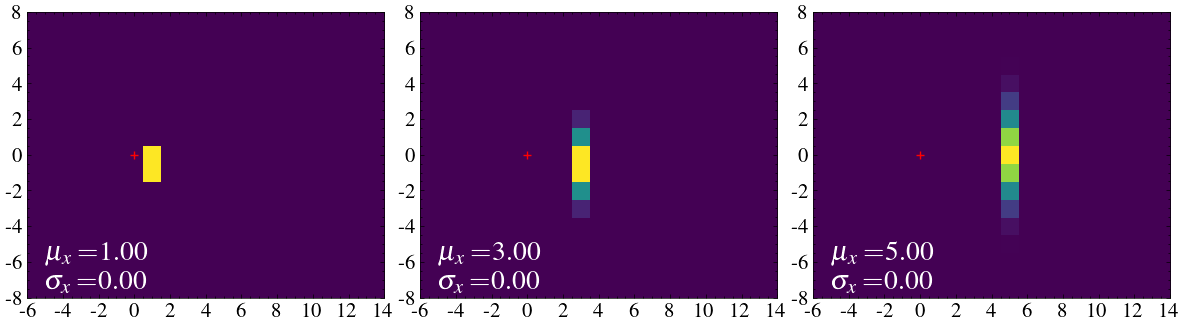

[[0.  0.  0. ]
 [0.5 0.5 0. ]
 [0.5 0.5 0. ]]
[[0.  0.5 0.5]
 [0.  0.5 0.5]
 [0.  0.  0. ]]
[[0.  0.  0. ]
 [0.5 0.5 0. ]
 [0.5 0.5 0. ]]
[[0.  0.5 0.5]
 [0.  0.5 0.5]
 [0.  0.  0. ]]
[[0.  0.  0. ]
 [0.5 0.5 0. ]
 [0.5 0.5 0. ]]
[[0.  0.5 0.5]
 [0.  0.5 0.5]
 [0.  0.  0. ]]
[[0.  0.  0. ]
 [0.5 0.5 0. ]
 [0.5 0.5 0. ]]
[[0.  0.5 0.5]
 [0.  0.5 0.5]
 [0.  0.  0. ]]
[[0.  0.  0. ]
 [0.5 0.5 0. ]
 [0.5 0.5 0. ]]
[[0.  0.5 0.5]
 [0.  0.5 0.5]
 [0.  0.  0. ]]
[[0.  0.  0. ]
 [0.5 0.5 0. ]
 [0.5 0.5 0. ]]


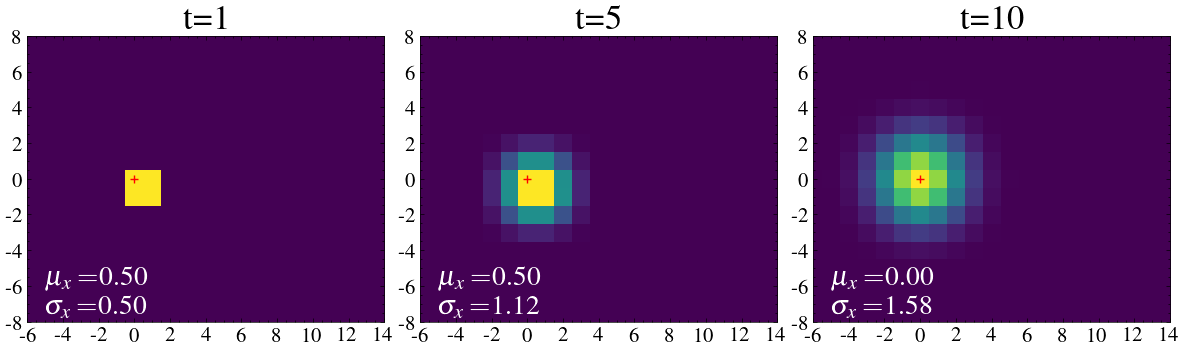

[[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
[[0.        0.6830127 0.1830127]
 [0.        0.6830127 0.1830127]
 [0.        0.        0.       ]]
[[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
[[0.        0.6830127 0.1830127]
 [0.        0.6830127 0.1830127]
 [0.        0.        0.       ]]
[[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
[[0.        0.6830127 0.1830127]
 [0.        0.6830127 0.1830127]
 [0.        0.        0.       ]]
[[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
[[0.        0.6830127 0.1830127]
 [0.        0.6830127 0.1830127]
 [0.        0.        0.       ]]
[[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
[[0.        0.6830127 0.1830127]
 [0.        0.6830127 0.1830127]
 [0.        0.        0.       ]]


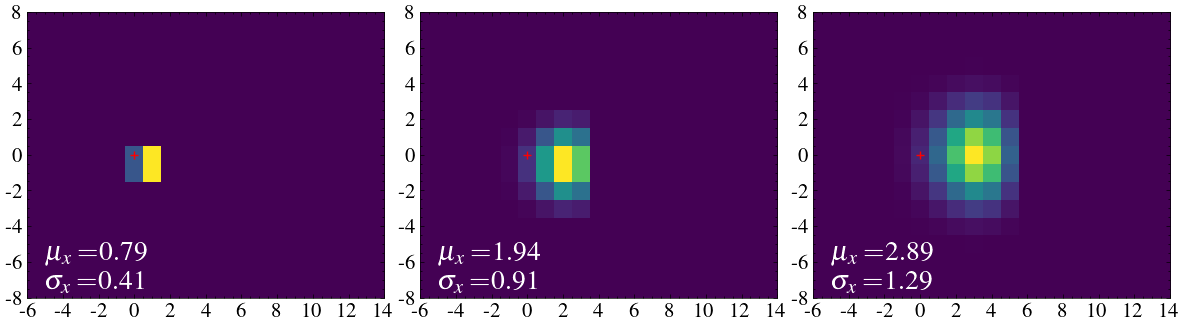

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.00000000e+00]]
[[0.00000000e+00 7.07106781e-01 5.55111512e-17]
 [0.00000000e+00 7.07106781e-01 5.55111512e-17]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.00000000e+00]]
[[0.00000000e+00 7.07106781e-01 5.55111512e-17]
 [0.00000000e+00 7.07106781e-01 5.55111512e-17]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.00000000e+00]]
[[0.00000000e+00 7.07106781e-01 5.55111512e-17]
 [0.00000000e+00 7.07106781e-01 5.55111512e-17]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.00000000e+00]
 [7.07106781e-01 5.55111512e-17 0.

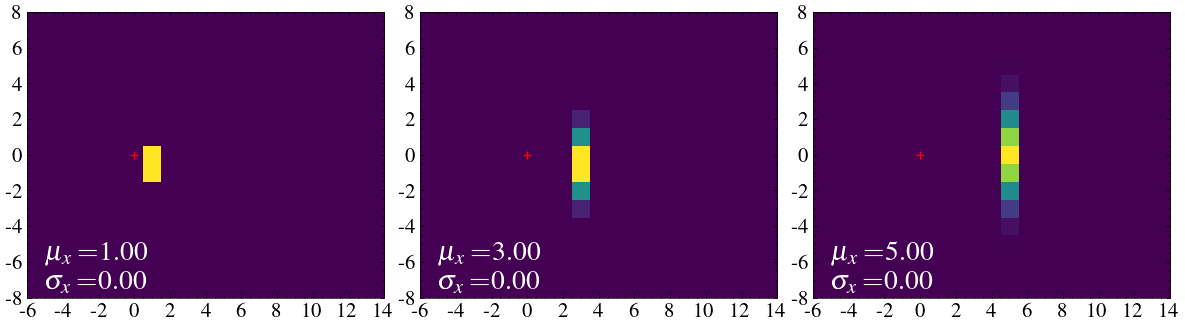

[[ 0.         0.         0.       ]
 [ 0.6830127 -0.1830127  0.       ]
 [ 0.6830127 -0.1830127  0.       ]]
[[ 0.         0.6830127 -0.1830127]
 [ 0.         0.6830127 -0.1830127]
 [ 0.         0.         0.       ]]
[[ 0.         0.         0.       ]
 [ 0.6830127 -0.1830127  0.       ]
 [ 0.6830127 -0.1830127  0.       ]]
[[ 0.         0.6830127 -0.1830127]
 [ 0.         0.6830127 -0.1830127]
 [ 0.         0.         0.       ]]
[[ 0.         0.         0.       ]
 [ 0.6830127 -0.1830127  0.       ]
 [ 0.6830127 -0.1830127  0.       ]]
[[ 0.         0.6830127 -0.1830127]
 [ 0.         0.6830127 -0.1830127]
 [ 0.         0.         0.       ]]
[[ 0.         0.         0.       ]
 [ 0.6830127 -0.1830127  0.       ]
 [ 0.6830127 -0.1830127  0.       ]]
[[ 0.         0.6830127 -0.1830127]
 [ 0.         0.6830127 -0.1830127]
 [ 0.         0.         0.       ]]
[[ 0.         0.         0.       ]
 [ 0.6830127 -0.1830127  0.       ]
 [ 0.6830127 -0.1830127  0.       ]]
[[ 0.         0.683

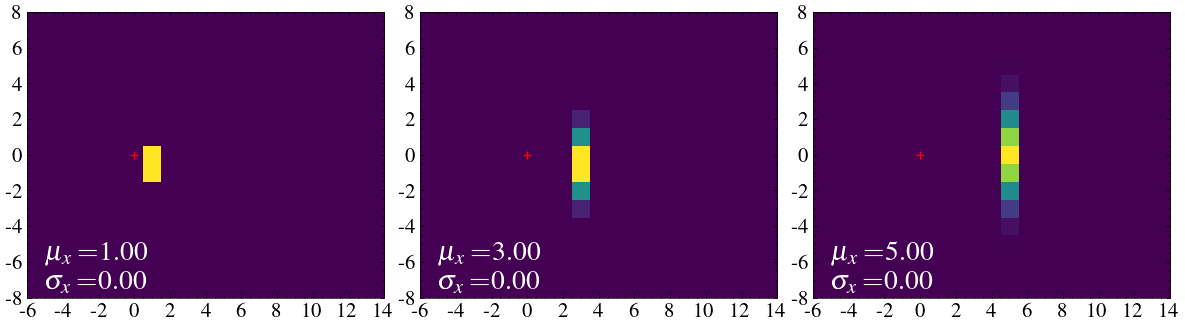

In [8]:
filters = np.zeros((3,3,1,1))
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 



#Get image height and width

vals_x = img[0, img.shape[1]//2, :, :]
vals_y = img[0, :, img.shape[2]//2, :]
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
	length_y = nonzeros[-1] - nonzeros[0] + 1
else:
	length_y = 0  # all zeros
nonzeros = np.nonzero(vals_x)[0]
if nonzeros.size > 0:
	length_x = nonzeros[-1] - nonzeros[0] + 1
else:
	length_x = 0  # all zeros



#step = 2**np.floor(np.log2(( (length_x) + np.max(timestamps) )// 5))


max_x = int(box_dims[0]*(.7))
min_x = -int(box_dims[0]*(.3))

max_y = box_dims[1]//2
min_y = -(box_dims[1]//2)

print(max_y, min_y)
print(length_x, length_y)




for activation in activations:
	directory = f"figures/{experiment_name}_{activation.__name__}_{k}x{k}"
	if not os.path.exists(directory):
		os.makedirs(directory)

	for beta2 in beta2s:

		
		images = []

		t = np.zeros((2,2))
		t[0,1] = np.sqrt(beta2)
		t[0, 0] = np.sqrt(1-beta2)


	
	
		#filters /= np.sum(np.abs(filters))
		
		w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)

		x = img






		#Generate Plot
		fig = plt.figure(figsize=(16,len(timestamps)+1))
		gs = fig.add_gridspec(1,len(timestamps)+1, wspace=0.1)

		'''ax0 = fig.add_subplot(gs[0], projection='3d')
		plot_filter_x(beta2, ax = ax0)
		ax0.axis('off')'''

		#for i, im in enumerate(images):	
		plot_num = 1
		for i in range(timestamps[-1]+1):
			if i in timestamps:

				ax = fig.add_subplot(gs[plot_num])
				plot_num+=1

				x = x/np.std(x)
				vals = x[0, x.shape[1]//2, :, :]
				vals = vals/np.sum(vals)

				pos = np.expand_dims(np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),-1)
				mean = tf.reduce_sum(pos*vals)
				var = tf.reduce_sum(((pos-mean)**2) * vals)
				std = np.sqrt(var)
				#print(mean, np.sqrt(var))
				
				im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
				ax.plot(mid, mid, marker = '+', color='red')

				'''arr =  mpatches.FancyArrowPatch((mid, mid), (mid+mean+std, mid),
										mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
				ax.add_patch(arr)'''


				ax.annotate(r'$\sigma_x=$'+f"{std:.2f}", (0.05,0.01), ha='left', va='bottom',color='white', xycoords='axes fraction', fontsize=20)
				ax.annotate(r'$\mu_x=$'+f"{mean:.2f}", (0.05,0.11), ha='left', va='bottom',color='white', xycoords='axes fraction', fontsize=20)
				#ax.annotate(r'$argmax_x=$'+f"{np.argmax(vals)-mid:.2f}", (0.05,.17), ha='left', va='bottom',color='white', xycoords='axes fraction')
				
				#ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
				#ax.arrow(, 112, dx=, dy= 0, color='black')




				ax.set(xlim=((mid + min_x, mid+max_x)) , ylim=((mid+min_y, (mid+max_y))))

				# Re-label ticks relative to midpoint
				xticks = ax.get_xticks()
				yticks = ax.get_yticks()

				#ax.set_xticklabels(np.arange(min_x, max_x+1, step=2))
				#ax.set_yticklabels(np.arange(min_y, max_y+1, step=2))
				xticks = np.arange(np.sign(min_x) * (np.abs(min_x)//2)*2, step+(max_x//2)*2, step=step) + mid
				yticks = np.arange(np.sign(min_y) * (np.abs(min_y)//2)*2, step+(max_y//2)*2, step=step) + mid
				ax.set_xticks(xticks)
				ax.set_yticks(yticks)
				ax.tick_params(axis='x', labelsize=15)
				ax.tick_params(axis='y', labelsize=15)


				ax.set_xticklabels([x - mid for x in xticks])
				ax.set_yticklabels([y - mid for y in yticks])



				#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
				#fig.colorbar(im, orientation='vertical')

				'''plt.close(fig) 
				buf = BytesIO()
				fig.savefig(buf, format="svg", dpi=fig.dpi, bbox_inches="tight")
				buf.seek(0)'''



				#ax0.imshow(im)
				#ax.axis('off')
				if beta2 == 0:
					ax.set_title(f"t={i}", fontsize=25)

				#images.append(Image.open(buf))
			filters = np.zeros((3,3,1,1))

			if i%2 == 0:
				filters[1:,0:2 ,0,0] = fft.idctn(t, norm="ortho")
			else:
				filters[0:2,1: ,0,0] = fft.idctn(t, norm="ortho")
			print(filters[:,:,0,0])
			w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)


			x = activation( tf.nn.conv2d(x, w , strides=(1,1), 
									padding='SAME') )


		fig.subplots_adjust(left=0.02, right=0.98, top=0.9, bottom=0.01, wspace=0.1)
		fig.savefig(os.path.join(directory, f"{experiment_name}_{k}x{k}__{activation.__name__}_{beta2}.pdf"), format="pdf", dpi=fig.dpi, bbox_inches="tight")
		plt.show()